To begin copy this notebook to your own drive:

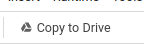


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [2]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
From (redirected): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn&confirm=t&uuid=e7f945b6-4d68-4a3a-ab0f-7fc942cc59e0
To: /content/glove.npy
100%|██████████| 480M/480M [00:03<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 77.9MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [6]:
import nltk
nltk.download('punkt_tab')
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [7]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [8]:
!pip install evaluate
from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [10]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.embedding_size = torch.FloatTensor(np.load("glove.npy")).size(1)
          self.classifier = nn.Sequential(
            nn.Linear(in_features=self.embedding_size, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.num_labels))
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      masked_embeddings = embeddings * attention_masks.unsqueeze(-1).float()
      sum_embeddings = masked_embeddings.sum(dim=1)
      sum_masks = attention_masks.sum(dim=1).unsqueeze(-1).clamp(min=1e-9)  # Avoid division by zero
      avg = sum_embeddings / sum_masks  # Compute the average embeddings
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [11]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 20, #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.012,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()



trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE
                  TensorBoardCallback()
                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.486600,0.409840,0.816320
2,0.407700,0.393136,0.825000
3,0.390300,0.385976,0.827280
4,0.386100,0.402862,0.818320
5,0.381700,0.378283,0.832720
6,0.376400,0.391954,0.824840
7,0.374900,0.381849,0.830800
8,0.369900,0.376967,0.834040
9,0.370400,0.379230,0.832200
10,0.365600,0.373156,0.836240


TrainOutput(global_step=3920, training_loss=0.3724086975564762, metrics={'train_runtime': 721.8292, 'train_samples_per_second': 692.685, 'train_steps_per_second': 5.431, 'total_flos': 0.0, 'train_loss': 0.3724086975564762, 'epoch': 20.0})

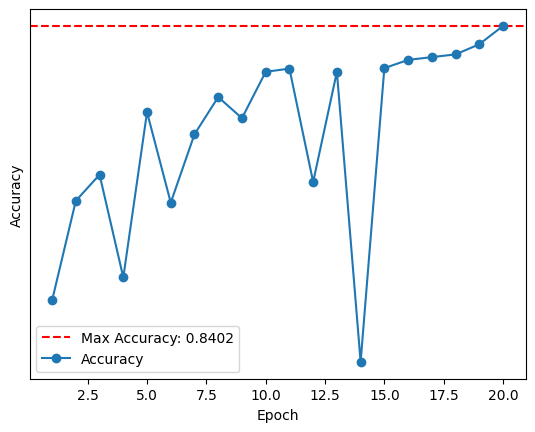

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
eval_accuracy = [d['eval_accuracy'] for d in trainer.state.log_history if 'eval_accuracy' in d ]
max_accuracy = np.max(np.array(eval_accuracy))
plt.axhline(y=max_accuracy, color='r', linestyle='dashed', label=f'Max Accuracy: {max_accuracy:.4f}')
plt.yticks(np.arange(0, 1))
epochs = np.arange(1, len(eval_accuracy) + 1)
plt.plot(epochs, eval_accuracy, marker='o', label='Accuracy')
plt.legend()
plt.show()

# **Section b**

In [14]:
from torch import nn
import torch
import numpy as np

class DropoutDAN(nn.Module):
    def __init__(self, dropout_prob=0.2):
        """
        Initialize the DAN model with word dropout.

        Args:
            dropout_prob (float): Probability of keeping a word's embedding (1 - dropout rate).
        """
        super().__init__()
        self.num_labels = 2
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
        self.embedding_size = torch.FloatTensor(np.load("glove.npy")).size(1)
        self.dropout_prob = dropout_prob

        # Define the classifier
        self.classifier = nn.Sequential(nn.Linear(self.embeddings.embedding_dim, self.num_labels))
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_masks, labels=None, training=True):
        """
        Forward pass with word dropout.

        Args:
            input_ids (torch.Tensor): Input token IDs.
            attention_masks (torch.Tensor): Attention masks for tokens.
            labels (torch.Tensor, optional): Ground truth labels.
            training (bool): Whether the model is in training mode.

        Returns:
            dict: A dictionary containing loss (if labels are provided) and logits.
        """
        # Get embeddings
        embeddings = self.embeddings(input_ids)

        # Apply word dropout during training
        if training:
            dropout_mask = torch.bernoulli(torch.ones_like(attention_masks) * (1 - self.dropout_prob)).unsqueeze(-1).float()
            embeddings = embeddings * dropout_mask

        # Mask the embeddings using attention mask
        masked_embeddings = embeddings * attention_masks.unsqueeze(-1).float()

        # Compute average embeddings
        sum_embeddings = masked_embeddings.sum(dim=1)
        sum_masks = attention_masks.sum(dim=1).unsqueeze(-1).clamp(min=1e-9)
        avg_embeddings = sum_embeddings / sum_masks

        # Pass the average through the classifier

        res = self.classifier(avg_embeddings)
        loss = self.loss(res,labels)
        return {"loss":loss,"logits":res}


In [15]:
def dropout(p):
  model = DropoutDAN(dropout_prob=p)

  trainer = (Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  TensorBoardCallback()
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))
  trainer.train()
  results = [d['eval_accuracy'] for d in trainer.state.log_history if 'eval_accuracy' in d ]
  return results

In [16]:
result5 = dropout(0.5)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.591900,0.542417,0.750880
2,0.518900,0.508397,0.764400
3,0.495400,0.493926,0.772600
4,0.480200,0.483598,0.775320
5,0.472500,0.475726,0.780520
6,0.464700,0.471318,0.783960
7,0.461000,0.468964,0.779880
8,0.462700,0.463383,0.783840
9,0.455700,0.461345,0.787280
10,0.455100,0.460589,0.789720


In [17]:
result4 = dropout(0.4)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.579500,0.525730,0.764280
2,0.501600,0.490896,0.776440
3,0.477500,0.474013,0.785200
4,0.461000,0.464234,0.789720
5,0.453800,0.459155,0.787800
6,0.447300,0.452956,0.794080
7,0.444300,0.452854,0.791200
8,0.442900,0.445653,0.795840
9,0.437800,0.443822,0.797800
10,0.434400,0.442395,0.799600


In [18]:
result3 = dropout(0.3)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.569700,0.511770,0.775080
2,0.485900,0.476348,0.785600
3,0.462700,0.458023,0.795600
4,0.446300,0.449310,0.796920
5,0.438000,0.444551,0.797480
6,0.432000,0.436869,0.805120
7,0.428800,0.437904,0.801320
8,0.426000,0.429981,0.806520
9,0.423400,0.430091,0.806880
10,0.418700,0.425184,0.809440


In [19]:
result2 = dropout(0.2)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.560500,0.500130,0.782200
2,0.474400,0.463779,0.794000
3,0.450700,0.444605,0.803640
4,0.434400,0.435388,0.805320
5,0.425700,0.432225,0.806480
6,0.419000,0.423570,0.809240
7,0.416000,0.425953,0.807680
8,0.412600,0.416507,0.815360
9,0.409100,0.417578,0.813560
10,0.406400,0.412590,0.815560


In [20]:
result1 = dropout(0.1)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.551600,0.488964,0.788760
2,0.463900,0.452338,0.801280
3,0.439500,0.432835,0.808920
4,0.422000,0.423906,0.812160
5,0.414000,0.422194,0.813400
6,0.408600,0.412477,0.816960
7,0.403500,0.411805,0.817280
8,0.400600,0.404950,0.822200
9,0.397600,0.404944,0.820720
10,0.395500,0.402080,0.822120


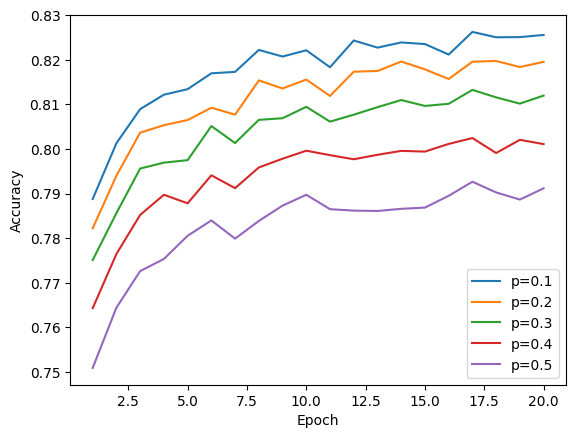

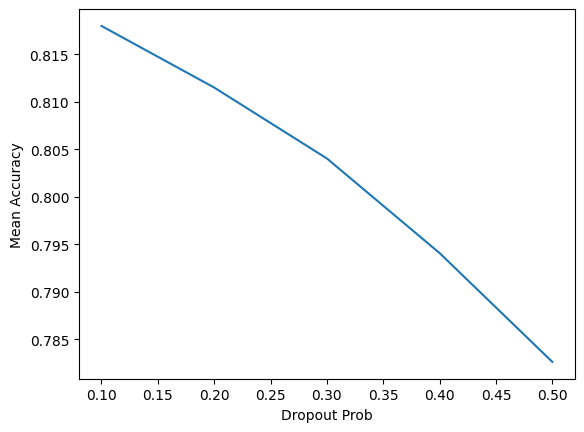

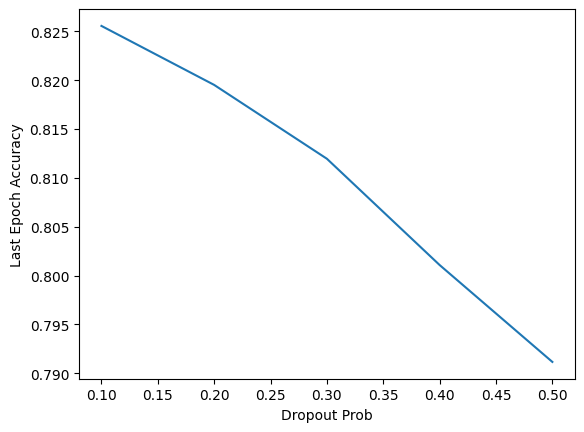

In [21]:
import matplotlib.pyplot as plt
import numpy as np

results_b = [result1, result2, result3, result4, result5]
ps = [0.1, 0.2, 0.3, 0.4, 0.5]
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
for i, result in enumerate(results_b):
    plt.plot(np.arange(1, 21), result, label=f"p={ps[i]:.1f}")
plt.legend()
plt.show()

plt.xlabel('Dropout Prob')
plt.ylabel('Mean Accuracy')
plt.plot(ps, np.mean(results_b, axis=1))
plt.show()

plt.xlabel('Dropout Prob')
plt.ylabel('Last Epoch Accuracy')
plt.plot(ps, np.array(results_b)[:, -1])
plt.show()

## Section **C**

In [22]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

class DynamicDAN(nn.Module):
  def __init__(self, p=0.0, hidden_layers=1, hidden_size=[256], activation_func=nn.ReLU()):
          super().__init__()
          self.num_labels = 2
          self.p = p
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.embedding_size = torch.FloatTensor(np.load("glove.npy")).size(1)

          classifier_args = []
          if hidden_layers == 0:
              classifier_args = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]
          else:
              for i in range(hidden_layers):
                  if i == 0:
                      classifier_args.append(nn.Linear(self.embeddings.embedding_dim, hidden_size[i]))
                  else:
                      classifier_args.append(nn.Linear(in_features=hidden_size[i-1], out_features=hidden_size[i]))
                  classifier_args.append(activation_func)

              classifier_args.append(nn.Linear(hidden_size[len(hidden_size)-1], self.num_labels))

          self.classifier = nn.Sequential(*classifier_args)
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      # Embedding Lookup
      embeddings = self.embeddings(input_ids)
      if self.training:
            dropout_mask = torch.bernoulli(torch.ones_like(attention_masks) * (1 - self.p)).unsqueeze(-1).float()
            embeddings = embeddings * dropout_mask

      masked_embeddings = embeddings * attention_masks.unsqueeze(-1).float()

      sum_embeddings = masked_embeddings.sum(dim=1)
      sum_masks = attention_masks.sum(dim=1).unsqueeze(-1)
      avg = sum_embeddings / sum_masks
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 20, #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.012,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

def run_with_hidden_layers(i):
    results_i = []
    model = DynamicDAN(hidden_layers=i, hidden_size=[256]*i)

    trainer_i=Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        callbacks = [
                    # YOUR CODE HERE
                    TensorBoardCallback()
                    # END YOUR END
        ],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )
    trainer_i.train()
    results_i=[d['eval_accuracy'] for d in trainer_i.state.log_history if 'eval_accuracy' in d ]
    return results_i

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
results_layer0 = run_with_hidden_layers(0)

{'loss': 0.5408, 'grad_norm': 0.08195451647043228, 'learning_rate': 0.0114, 'epoch': 1.0}
{'eval_loss': 0.47724562883377075, 'eval_accuracy': 0.79448, 'eval_runtime': 13.3927, 'eval_samples_per_second': 1866.692, 'eval_steps_per_second': 233.336, 'epoch': 1.0}
{'loss': 0.4537, 'grad_norm': 0.060910820960998535, 'learning_rate': 0.0108, 'epoch': 2.0}
{'eval_loss': 0.4396606385707855, 'eval_accuracy': 0.80796, 'eval_runtime': 13.5483, 'eval_samples_per_second': 1845.254, 'eval_steps_per_second': 230.657, 'epoch': 2.0}
{'loss': 0.4282, 'grad_norm': 0.059526797384023666, 'learning_rate': 0.0102, 'epoch': 3.0}
{'eval_loss': 0.42173290252685547, 'eval_accuracy': 0.81588, 'eval_runtime': 13.7107, 'eval_samples_per_second': 1823.387, 'eval_steps_per_second': 227.923, 'epoch': 3.0}
{'loss': 0.4111, 'grad_norm': 0.0706254318356514, 'learning_rate': 0.009600000000000001, 'epoch': 4.0}
{'eval_loss': 0.41187363862991333, 'eval_accuracy': 0.81932, 'eval_runtime': 13.5494, 'eval_samples_per_second': 

In [24]:
results_layer1 = run_with_hidden_layers(1)

{'loss': 0.4723, 'grad_norm': 0.12808838486671448, 'learning_rate': 0.0114, 'epoch': 1.0}
{'eval_loss': 0.4445284903049469, 'eval_accuracy': 0.78932, 'eval_runtime': 13.801, 'eval_samples_per_second': 1811.466, 'eval_steps_per_second': 226.433, 'epoch': 1.0}
{'loss': 0.4096, 'grad_norm': 0.5358642935752869, 'learning_rate': 0.0108, 'epoch': 2.0}
{'eval_loss': 0.39005258679389954, 'eval_accuracy': 0.82624, 'eval_runtime': 13.7462, 'eval_samples_per_second': 1818.679, 'eval_steps_per_second': 227.335, 'epoch': 2.0}
{'loss': 0.3888, 'grad_norm': 0.19077958166599274, 'learning_rate': 0.0102, 'epoch': 3.0}
{'eval_loss': 0.4232376217842102, 'eval_accuracy': 0.80684, 'eval_runtime': 13.6993, 'eval_samples_per_second': 1824.911, 'eval_steps_per_second': 228.114, 'epoch': 3.0}
{'loss': 0.3817, 'grad_norm': 0.09682022035121918, 'learning_rate': 0.009600000000000001, 'epoch': 4.0}
{'eval_loss': 0.382876455783844, 'eval_accuracy': 0.83084, 'eval_runtime': 13.6777, 'eval_samples_per_second': 1827.7

In [25]:
results_layer2 = run_with_hidden_layers(2)

{'loss': 0.4871, 'grad_norm': 0.5662379860877991, 'learning_rate': 0.0114, 'epoch': 1.0}
{'eval_loss': 0.444862961769104, 'eval_accuracy': 0.79592, 'eval_runtime': 13.9089, 'eval_samples_per_second': 1797.411, 'eval_steps_per_second': 224.676, 'epoch': 1.0}
{'loss': 0.4093, 'grad_norm': 0.8913390040397644, 'learning_rate': 0.0108, 'epoch': 2.0}
{'eval_loss': 0.385593056678772, 'eval_accuracy': 0.82928, 'eval_runtime': 13.7778, 'eval_samples_per_second': 1814.516, 'eval_steps_per_second': 226.815, 'epoch': 2.0}
{'loss': 0.3937, 'grad_norm': 0.17841355502605438, 'learning_rate': 0.0102, 'epoch': 3.0}
{'eval_loss': 0.41783273220062256, 'eval_accuracy': 0.80792, 'eval_runtime': 14.0845, 'eval_samples_per_second': 1774.995, 'eval_steps_per_second': 221.874, 'epoch': 3.0}
{'loss': 0.3868, 'grad_norm': 0.5661848783493042, 'learning_rate': 0.009600000000000001, 'epoch': 4.0}
{'eval_loss': 0.39157989621162415, 'eval_accuracy': 0.82928, 'eval_runtime': 14.0455, 'eval_samples_per_second': 1779.93

In [26]:
results_layer3 = run_with_hidden_layers(3)

{'loss': 0.4977, 'grad_norm': 0.6817225813865662, 'learning_rate': 0.0114, 'epoch': 1.0}
{'eval_loss': 0.5034908652305603, 'eval_accuracy': 0.76644, 'eval_runtime': 14.2627, 'eval_samples_per_second': 1752.827, 'eval_steps_per_second': 219.103, 'epoch': 1.0}
{'loss': 0.4219, 'grad_norm': 0.5139964818954468, 'learning_rate': 0.0108, 'epoch': 2.0}
{'eval_loss': 0.41078945994377136, 'eval_accuracy': 0.8142, 'eval_runtime': 14.2638, 'eval_samples_per_second': 1752.686, 'eval_steps_per_second': 219.086, 'epoch': 2.0}
{'loss': 0.3992, 'grad_norm': 0.972301721572876, 'learning_rate': 0.0102, 'epoch': 3.0}
{'eval_loss': 0.390568345785141, 'eval_accuracy': 0.829, 'eval_runtime': 14.083, 'eval_samples_per_second': 1775.187, 'eval_steps_per_second': 221.898, 'epoch': 3.0}
{'loss': 0.3963, 'grad_norm': 0.5761316418647766, 'learning_rate': 0.009600000000000001, 'epoch': 4.0}
{'eval_loss': 0.40199920535087585, 'eval_accuracy': 0.8266, 'eval_runtime': 14.2143, 'eval_samples_per_second': 1758.794, 'ev

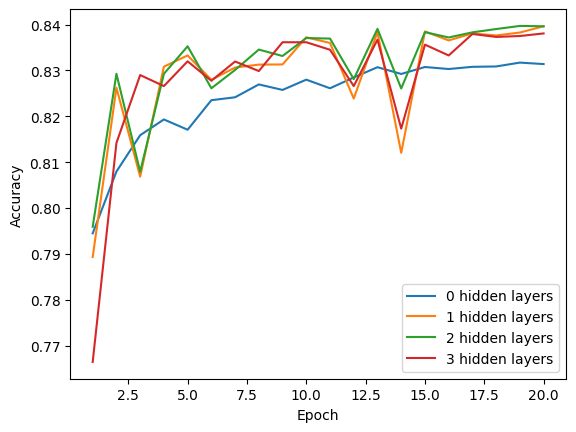

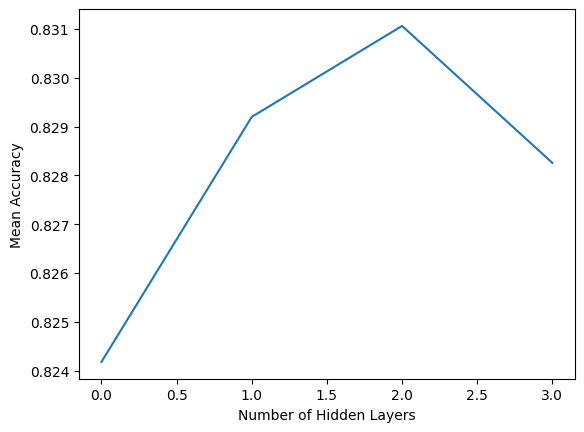

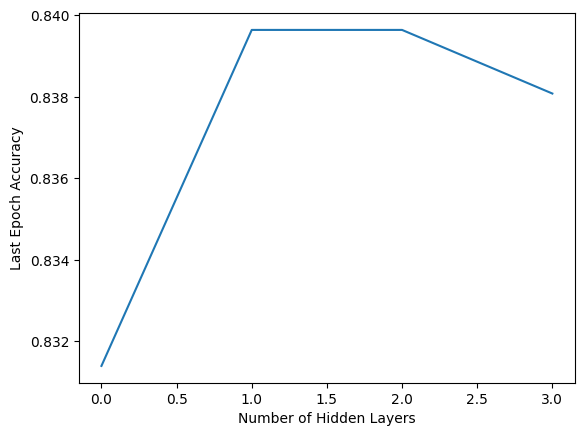

In [27]:
from matplotlib import pyplot as plt
import numpy as np

results = [results_layer0, results_layer1, results_layer2, results_layer3]
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
for i, result in enumerate(results):
  plt.plot(np.arange(1, 21), result, label=f"{i} hidden layers")
plt.legend()
plt.show()

plt.xlabel('Number of Hidden Layers')
plt.ylabel('Mean Accuracy')
plt.plot(np.arange(4), np.mean(results, axis=1))
plt.show()

plt.xlabel('Number of Hidden Layers')
plt.ylabel('Last Epoch Accuracy')
plt.plot(np.arange(4), np.array(results)[:, -1])
plt.show()

# Section D

In [28]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 20, #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate= 0.012,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")


def run_with_activation_function(activation_function):
  model = DynamicDAN(activation_func = activation_function)

  trainer_func=(Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  TensorBoardCallback()
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))
  trainer_func.train()
  results_func = [d['eval_accuracy'] for d in trainer_func.state.log_history if 'eval_accuracy' in d ]
  return results_func

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
relu_result = run_with_activation_function(nn.ReLU())

{'loss': 0.4723, 'grad_norm': 0.12808838486671448, 'learning_rate': 0.0114, 'epoch': 1.0}
{'eval_loss': 0.4445284903049469, 'eval_accuracy': 0.78932, 'eval_runtime': 13.8892, 'eval_samples_per_second': 1799.954, 'eval_steps_per_second': 224.994, 'epoch': 1.0}
{'loss': 0.4096, 'grad_norm': 0.5358642935752869, 'learning_rate': 0.0108, 'epoch': 2.0}
{'eval_loss': 0.39005258679389954, 'eval_accuracy': 0.82624, 'eval_runtime': 14.0154, 'eval_samples_per_second': 1783.756, 'eval_steps_per_second': 222.97, 'epoch': 2.0}
{'loss': 0.3888, 'grad_norm': 0.19077958166599274, 'learning_rate': 0.0102, 'epoch': 3.0}
{'eval_loss': 0.4232376217842102, 'eval_accuracy': 0.80684, 'eval_runtime': 13.7546, 'eval_samples_per_second': 1817.569, 'eval_steps_per_second': 227.196, 'epoch': 3.0}
{'loss': 0.3817, 'grad_norm': 0.09682022035121918, 'learning_rate': 0.009600000000000001, 'epoch': 4.0}
{'eval_loss': 0.382876455783844, 'eval_accuracy': 0.83084, 'eval_runtime': 13.8952, 'eval_samples_per_second': 1799.1

In [30]:
sigmoid_result = run_with_activation_function(nn.Sigmoid())

{'loss': 0.5391, 'grad_norm': 0.8260404467582703, 'learning_rate': 0.0114, 'epoch': 1.0}
{'eval_loss': 0.4137776494026184, 'eval_accuracy': 0.81692, 'eval_runtime': 13.9826, 'eval_samples_per_second': 1787.935, 'eval_steps_per_second': 223.492, 'epoch': 1.0}
{'loss': 0.4203, 'grad_norm': 0.15520355105400085, 'learning_rate': 0.0108, 'epoch': 2.0}
{'eval_loss': 0.3989209830760956, 'eval_accuracy': 0.82208, 'eval_runtime': 14.1706, 'eval_samples_per_second': 1764.215, 'eval_steps_per_second': 220.527, 'epoch': 2.0}
{'loss': 0.3907, 'grad_norm': 0.37294912338256836, 'learning_rate': 0.0102, 'epoch': 3.0}
{'eval_loss': 0.38601377606391907, 'eval_accuracy': 0.83012, 'eval_runtime': 13.7958, 'eval_samples_per_second': 1812.144, 'eval_steps_per_second': 226.518, 'epoch': 3.0}
{'loss': 0.3909, 'grad_norm': 0.07704217731952667, 'learning_rate': 0.009600000000000001, 'epoch': 4.0}
{'eval_loss': 0.38709598779678345, 'eval_accuracy': 0.82912, 'eval_runtime': 13.9607, 'eval_samples_per_second': 179

In [31]:
mish_result = run_with_activation_function(nn.Mish())

{'loss': 0.4834, 'grad_norm': 0.19075891375541687, 'learning_rate': 0.0114, 'epoch': 1.0}
{'eval_loss': 0.47487807273864746, 'eval_accuracy': 0.77344, 'eval_runtime': 13.7899, 'eval_samples_per_second': 1812.917, 'eval_steps_per_second': 226.615, 'epoch': 1.0}
{'loss': 0.4108, 'grad_norm': 0.3470470905303955, 'learning_rate': 0.0108, 'epoch': 2.0}
{'eval_loss': 0.3972269892692566, 'eval_accuracy': 0.82176, 'eval_runtime': 14.1477, 'eval_samples_per_second': 1767.073, 'eval_steps_per_second': 220.884, 'epoch': 2.0}
{'loss': 0.3889, 'grad_norm': 0.37798646092414856, 'learning_rate': 0.0102, 'epoch': 3.0}
{'eval_loss': 0.4168245196342468, 'eval_accuracy': 0.81028, 'eval_runtime': 14.0609, 'eval_samples_per_second': 1777.985, 'eval_steps_per_second': 222.248, 'epoch': 3.0}
{'loss': 0.3819, 'grad_norm': 0.08733516186475754, 'learning_rate': 0.009600000000000001, 'epoch': 4.0}
{'eval_loss': 0.3848015367984772, 'eval_accuracy': 0.83016, 'eval_runtime': 13.987, 'eval_samples_per_second': 1787.

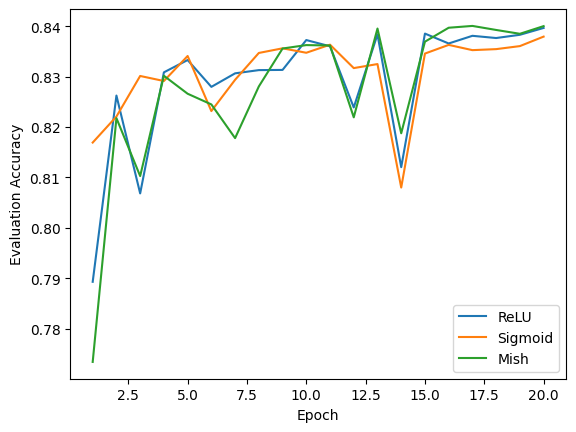

In [32]:
from matplotlib import pyplot as plt
import numpy as np

resultsd = [relu_result, sigmoid_result, mish_result]
activations = ['ReLU', 'Sigmoid', 'Mish']
plt.xlabel('Epoch')
plt.ylabel('Evaluation Accuracy')
for i, result in enumerate(resultsd):
  plt.plot(np.arange(1, 21), result, label=f"{activations[i]}")
plt.legend()
plt.show()

# Section E

In [33]:
predictions = trainer.predict(small_eval_dataset)
predicted_labels = np.argmax(predictions[0], axis=1)
labels = np.array(small_eval_dataset['labels'])
wrong_predictions_idx = (predicted_labels != labels).nonzero()[0]
wrong_idx = np.random.choice(wrong_predictions_idx, size=5, replace=False)
wrong_texts = np.array(small_eval_dataset['text'])[wrong_idx]
for i, (idx, text) in enumerate(zip(wrong_idx, wrong_texts)):
  print(f"text {i}:")
  print(f"prediction: {predicted_labels[idx]}, label: {labels[idx]}")
  print(f"model output: {predictions[0][idx]}")
  print(text)

text 0:
prediction: 1, label: 0
model output: [-0.9643506  0.9666286]
This is just another one of those "American finds romance with charming foreigner in exotic European locale." This genre has been cinematically bankrupt since the 1950s, yet they continue to churn them out. I let my girlfriend talk me into seeing this - bad idea, we both hated it. If all you want to see is Tuscany, try watching "Stealing Beauty" with Liv Tyler - a marginally better movie.<br /><br />This types of genre movies are very Hallmark Greeting Card-ish.
text 1:
prediction: 1, label: 0
model output: [-0.66438043  0.59356654]
Racing enthusiast Fabian (as Tommy Callahan) smokes, drinks, and suffers blackouts while juggling feelings for alluring brunette Annette Funicello (as Francie Madsen) and blonde mainstay Diane McBain (as Annie Blaine). Complicating matters are Ms. Funicello's boozy race car boyfriend Warren Berlinger (as Eddie Sands), and her father Jan Murray (as Pete Madsen), who encourages the reckless